Execute this cell below only when hosting code remotely.
This cell lets you import all code from https://github.com/maviddoerdijk/bsc-thesis/blob/main/src/.

Warning: when hosting remotely, none of the helper function code can be changed. Unless when you use specific branches.


In [41]:
branch = "helper-function-additions"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src

Cloning into 'bsc-thesis'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 125 (delta 61), reused 58 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (125/125), 4.09 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/bsc-thesis/src/bsc-thesis/src/bsc-thesis/src/bsc-thesis/src


In [43]:
from preprocessing.data_preprocessing import filter_pairs_data


ImportError: cannot import name 'filter_pairs_data' from 'preprocessing.data_preprocessing' (/content/bsc-thesis/src/preprocessing/data_preprocessing.py)

Now, let's start the notebook.

In [ ]:
# Install missing Python packages in Google Colab
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets

# Gather data

In [8]:
from data.data_collection import gather_data

startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIds = list(set(['ITOT', 'ACWI', 'IWV', 'VT', 'VTI',
                'DIA', 'RSP', 'IOO', 'IVV', 'SPY',
                'SHE', 'IWM', 'OEF', 'QQQ',
                'CVY', 'RPG', 'RPV', 'IWB', 'IWF',
                'IWD', 'IVW', 'IVE', 'PKW',
                'PRF', 'SDY', 'VV', 'VUG',
                'VTV', 'MGC', 'MGK', 'MGV', 'VIG',
                'VYM', 'DTN', 'DLN', 'MDY', 'DVY',
                'IWR', 'IWP', 'IWS', 'IJH', 'IJK',
                'IJJ', 'PDP', 'DON', 'IWC', 'IWM',
                'IWO', 'IWN', 'IJR', 'IJT', 'IJS',
                'EEB', 'IDV', 'ACWX', 'BKF', 'EFA',
                'EFG', 'EFV', 'SCZ', 'EEM', 'PID',
                'DWX', 'DEM', 'DGS', 'AAXJ', 'EZU',
                'EPP', 'IEV', 'ILF', 'FEZ', 'VGK',
                'VPL', 'DFE', 'EWA', 'EWC', 'EWG',
                'EWI', 'EWJ', 'EWD', 'EWL', 'EWP',
                'EWU', 'DXJ', 'EWZ', 'FXI', 'EWH',
                'EWW', 'RSX', 'EWS', 'EWM','EWY',
                'EWT', 'EPI', 'XLY', 'IYC', 'ITB',
                'XHB', 'VCR','XLP', 'IYK', 'VDC',
                'XLE', 'IYE', 'IGE',
                'VDE', 'QCLN', 'XLF','IYF', 'KBE',
                'KRE', 'VFH']))


data = gather_data(startDateStr, endDateStr, instrumentIds)
data_close = data['close']
data_open = data['open']
data_high = data['high']
data_low = data['low']
data_vol = data['vol']

[*********************100%***********************]  111 of 111 completed


# Prepocessing
### Filtering ETFs for liquidity

In [9]:
data['yfinance_formatted'][['QQQ', 'IJJ']].xs('Volume', level='Price', axis=1)


Ticker,QQQ,IJJ
Date,,
2008-10-01,174033300,8870600
2008-10-02,192124000,283800
2008-10-03,272116100,939000
2008-10-06,394046600,897000
2008-10-07,329365700,414000
...,...,...
2018-09-25,25277500,202000
2018-09-26,36210600,119400
2018-09-27,33113300,153600


# Find Co-Integrated Pairs

First, let's try to estimate the time we need.

In [19]:
import time
n_test_pairs = 10
start_time = time.time()
first_n_test_cols = data['yfinance_formatted'].columns.get_level_values('Ticker').unique()[:n_test_pairs]
scores, pvalues, pairs = find_cointegrated_pairs(data['yfinance_formatted'][first_n_test_cols])
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
seconds_per_pair = (end_time - start_time) / n_test_pairs
print(f"Seconds per pair: {seconds_per_pair:.2f}")

Missing data for pair: MGV, EEB
Missing data for pair: IWC, EEB
Missing data for pair: VTV, EEB
Missing data for pair: XLF, EEB
Missing data for pair: IWF, EEB
Missing data for pair: IWD, EEB
Missing data for pair: SPY, EEB
Missing data for pair: IYK, EEB
Missing data for pair: IVV, EEB
Completed 45 pairs
Execution time: 8.55 seconds
Seconds per pair: 0.86


In [22]:
from enum import unique


n_cols = len(data['yfinance_formatted'].columns.get_level_values('Ticker').unique())
max_cols = 20
if n_cols > max_cols and max_cols > 0:
    cols = data['yfinance_formatted'].columns.get_level_values('Ticker').unique()[:max_cols]
    n_cols = max_cols
else:
    cols = data['yfinance_formatted'].columns.get_level_values('Ticker').unique()
first_n_cols = data['yfinance_formatted'].columns.get_level_values('Ticker').unique()[:n_cols]
# combinatorially find number of unique pairs of columns
unique_pairs = n_cols * (n_cols - 1) / 2
expected_time = unique_pairs * seconds_per_pair
print(f"Expected time to run all pairs: {expected_time / 60:.2f} minutes")

Expected time to run all pairs: 2.71 minutes


In [33]:
from preprocessing.data_preprocessing import filter_pairs_data


ImportError: cannot import name 'filter_pairs_data' from 'preprocessing.data_preprocessing' (/content/bsc-thesis/src/preprocessing/data_preprocessing.py)

In [30]:
%load_ext autoreload
%autoreload 2

from preprocessing.cointegration import find_cointegrated_pairs
from utils.visualization import plot_heatmap
from preprocessing.data_preprocessing import filter_pairs_data

# First, we'll try it for a smaller (random) subset of the data
import time
start_time = time.time()
scores, pvalues, pairs = find_cointegrated_pairs(data['yfinance_formatted'][first_n_cols])
# TODO: remove all perfectly cointegrated  variables where the error code shown below is given:
# /content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case. \ result = coint(S1, S2)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
pairs_data_filtered

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Missing data for pair: MGV, EEB
Missing data for pair: IWC, EEB
Missing data for pair: VTV, EEB
Missing data for pair: XLF, EEB
Missing data for pair: IWF, EEB
Missing data for pair: IWD, EEB
Missing data for pair: SPY, EEB
Missing data for pair: IYK, EEB
Missing data for pair: IVV, EEB


/content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(S1, S2)
/content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(S1, S2)
/content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(S1, S2)
/content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(S1, S2)
/content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  result = coint(S1, S2)
/content/bsc-thesis/

Completed 190 pairs
Execution time: 34.57 seconds


[(('KBE', 'VFH'), np.float64(5.419965145373005e-05)),
 (('MGV', 'MDY'), np.float64(0.0003471602072689424)),
 (('XLF', 'KBE'), np.float64(0.000558867649307414)),
 (('KBE', 'MDY'), np.float64(0.0031644512067920275)),
 (('KBE', 'PRF'), np.float64(0.007499653326729589)),
 (('IWF', 'KBE'), np.float64(0.011547985971317495)),
 (('VTV', 'MDY'), np.float64(0.011913681187257007)),
 (('XLF', 'VFH'), np.float64(0.014371946531150459)),
 (('IWN', 'MDY'), np.float64(0.014669490575021878)),
 (('IWC', 'KBE'), np.float64(0.019839463242342495)),
 (('IWC', 'PRF'), np.float64(0.023863530899490514)),
 (('IWC', 'VTV'), np.float64(0.025000239274752225)),
 (('MGV', 'IWC'), np.float64(0.025313951724643142)),
 (('VTV', 'PRF'), np.float64(0.027426478587651803)),
 (('SPY', 'KBE'), np.float64(0.028967681050707204)),
 (('IVV', 'KBE'), np.float64(0.030969481993979187)),
 (('VTV', 'KBE'), np.float64(0.03208997949575676)),
 (('PRF', 'IWN'), np.float64(0.0342547599819043)),
 (('MGV', 'PRF'), np.float64(0.036458999056685

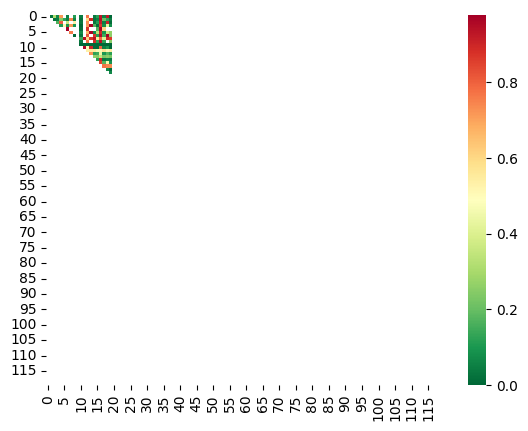

In [27]:
from utils.visualization import plot_heatmap
plot_heatmap(pvalues)

In [31]:
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
print(f"Most highly cointegrated pair: {ticker_a} and {ticker_b}")


Most highly cointegrated pair: KBE and VFH
